In [1]:
import numpy as np
import scipy as sp
import random as rand
#import network_equ_xy_energy 
#import network_gen_isotropic 
import openpyxl 
import collections
import timeit
import glob
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import math
from scipy.optimize import fsolve, root
import scipy.optimize as optimize

In [2]:
title_font = {'fontname':'Arial', 'size':'15', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'13'}


In [3]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

In [4]:

def eval_sigma_Ogden(mu, alpha,lamx,lamy,eta):
    lamz = 1./(lamx*lamy)
    p = eta*mu*lamz**alpha
    sigmax = -p+eta*mu*lamx**alpha
    sigmay = -p+eta*mu*lamy**alpha
    return sigmax,sigmay

In [5]:
def eval_Psi_ogden(mu,alpha,lamx,lamy,lamz):
    return mu/alpha*(lamx**alpha+lamy**alpha+lamz**alpha-3)


In [6]:
def evalMullins(Wmax,W,r,m,beta):
    eta = 1-(1.0/r)*sp.special.erf( (Wmax-W)/(m+beta*Wmax))
    return eta

In [32]:
# Do a couple of simulations with uniaxial loading for Mullins material, two cycles 
n1 = 25
lamdax_ls1 = np.linspace(1,1.25,n1)
sigmax_ls1 = np.zeros((n1))
n2 = 25
lamdax_ls2 = np.linspace(1.25,1,n2)
sigmax_ls2 = np.zeros((n2))
n3 = 50
lamdax_ls3 = np.linspace(1.0,1.3,n3)
sigmax_ls3 = np.zeros((n3))
n4 = 50
lamdax_ls4 = np.linspace(1.0,1.3,n4)
sigmax_ls4 = np.zeros((n4))
Wmax = 0
eta = 1
mu = 0.5
alpha = 8
r = 2
m = 0.1
beta = 0.1
for i in range(n1):
    lamx = lamdax_ls1[i]
    lamy = 1/np.sqrt(lamx)
    lamz = 1/np.sqrt(lamx)
    W = eval_Psi_ogden(mu,alpha,lamx,lamy,lamz)
    if W>Wmax:
        Wmax = W 
    eta = evalMullins(Wmax,W,r,m,beta)
    sigmax,sigmay = eval_sigma_Ogden(mu, alpha,lamx,lamy,eta)
    sigmax_ls1[i] = sigmax
for i in range(n2):
    lamx = lamdax_ls2[i]
    lamy = 1/np.sqrt(lamx)
    lamz = 1/np.sqrt(lamx)
    W = eval_Psi_ogden(mu,alpha,lamx,lamy,lamz)
    if W>Wmax:
        Wmax = W 
    eta = evalMullins(Wmax,W,r,m,beta)
    sigmax,sigmay = eval_sigma_Ogden(mu, alpha,lamx,lamy,eta)
    sigmax_ls2[i] = sigmax
for i in range(n3):
    lamx = lamdax_ls3[i]
    lamy = 1/np.sqrt(lamx)
    lamz = 1/np.sqrt(lamx)
    W = eval_Psi_ogden(mu,alpha,lamx,lamy,lamz)
    if W>Wmax:
        Wmax = W 
    eta = evalMullins(Wmax,W,r,m,beta)
    sigmax,sigmay = eval_sigma_Ogden(mu, alpha,lamx,lamy,eta)
    sigmax_ls3[i] = sigmax
for i in range(n4):
    lamx = lamdax_ls4[i]
    lamy = 1/np.sqrt(lamx)
    lamz = 1/np.sqrt(lamx)
    W = eval_Psi_ogden(mu,alpha,lamx,lamy,lamz)
    if W>Wmax:
        Wmax = W 
    eta = evalMullins(Wmax,W,r,m,beta)
    sigmax,sigmay = eval_sigma_Ogden(mu, alpha,lamx,lamy,eta)
    sigmax_ls4[i] = sigmax
    

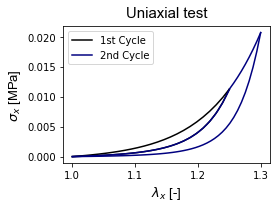

In [33]:
fig, axs = plt.subplots(figsize=(4,3))

plt.plot(lamdax_ls1,sigmax_ls1,label='1st Cycle',color=[0,0,0])
plt.plot(lamdax_ls2,sigmax_ls2,color=[0,0,0])
plt.plot(lamdax_ls3,sigmax_ls3,label='2nd Cycle',color=[0,0,0.5])
plt.plot(lamdax_ls4,sigmax_ls4,color=[0,0,0.5])
plt.legend(loc=2)
plt.xlabel(r'$\lambda_x$ [-]',**axis_font)
plt.ylabel(r'$\sigma_x$ [MPa]',**axis_font)
plt.title('Uniaxial test',**title_font)
plt.tight_layout()
#plt.savefig('Ogden_mullins.png',dpi=200)

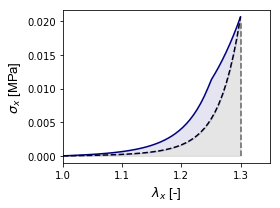

In [51]:
fig, axs = plt.subplots(figsize=(4,3))

plt.plot(lamdax_ls3,sigmax_ls3,label='2nd Cycle',color=[0,0,0.5])
plt.plot(lamdax_ls4,sigmax_ls4,color=[0,0,0.1],linestyle='--')
plt.fill_between(lamdax_ls4,sigmax_ls4,sigmax_ls3,color=[0,0,0.5],alpha=0.1)
plt.fill_between(lamdax_ls4,np.zeros((n4)),sigmax_ls4,color=[0,0,0],alpha=0.1)
plt.plot(1.3*np.ones(20),np.linspace(0,0.02,20),color=[0.4,0.4,0.4],linestyle='--')
#plt.legend(loc=2)
plt.xlabel(r'$\lambda_x$ [-]',**axis_font)
plt.ylabel(r'$\sigma_x$ [MPa]',**axis_font)
plt.xlim([1,1.35])
#plt.title('Uniaxial test',**title_font)
plt.tight_layout()
plt.savefig('G_Gd.png',dpi=200)

In [7]:
# Do biaxial loading, first loading with nyi steps to lamyi, then nx steps along x 

Wmax = 0
eta = 1
mu = 0.5
alpha = 8
r = 5
m = 0.1
beta = 0.1

nx = 21
ny = 21
lamy_ls = np.linspace(1,1.25,nx)
#lamy_ls = np.array([1.   , 1.1,  1.2, 1.025, 1.05 , 1.075,  1.125, 1.15 , 1.175 ,     1.225, 1.25 ])
lamx_ls = np.linspace(1,1.25,ny)
X_vec = np.zeros((nx*ny,2))
Z_vec = np.zeros((nx*ny,1))
PK2_vec = np.zeros((nx*ny,2))
C_vec = np.zeros((nx*ny,2))
dlam = lamy_ls[1]-lamy_ls[0]
count = 0
for i in range(ny):
    # load in y
    lamy = lamy_ls[i]
    # assume we replace half way and test a different material 
    if i==2 or i==4 or i==6 or i==8 or i==10:
        Wmax = 0
        mu = 0.5+(np.random.rand()-0.5)*0.5
        alpha = 8+(np.random.rand()-0.5)*1
    for j in range(nx):
        # load in x
        lamx = lamx_ls[j] 
        lamz = 1./lamx/lamy
        W = eval_Psi_ogden(mu,alpha,lamx,lamy,lamz)
        if W>Wmax:
            Wmax = W 
        eta = evalMullins(Wmax,W,r,m,beta)
        #print('W=%f, Wmax=%f'%(W,Wmax))
        print(eta)
        Z_vec[count] = eta*W
        X_vec[count,0] = lamx**2+lamy**2+lamz**2
        X_vec[count,1] = lamx**2*lamy**2+lamy**2*lamz**2+lamz**2*lamy**2
        sigmax,sigmay = eval_sigma_Ogden(mu, alpha,lamx,lamy,eta)
        sigma = np.array([[sigmax,0],[0,sigmay]])
        F = np.array([[lamx,0],[0,lamy]])
        Finv = np.array([[1.0/lamx,0],[0,1.0/lamy]])
        PK2 = np.dot(Finv,np.dot(sigma,Finv.transpose()))
        PK2_vec[count,0] = PK2[0,0]
        PK2_vec[count,1] = PK2[1,1]
        C_vec[count,0] = lamx**2
        C_vec[count,1] = lamy**2
        count+=1


    


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.8007617989928771
0.8007945211336704
0.8008630683077572
0.8009748707612434
0.8011430912991127
0.8013889346415849
0.801745534181094
0.8022642138544699
0.8030243735086021
0.8041488371802703
0.8058271729831441
0.8083499711826447
0.8121566319647259
0.8178963129689719
0.8264935604156362
0.8391930730101189
0.857529703021274
0.8831361663396204
0.9172886445467117
0.960156253990424
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.8116110315800033
0.8120242833792128
0.8126646688624548
0.8135584493880387
0.8147450329882577
0.8162792152417363
0.8182343719079639
0.8207066741672782
0.823820369279121
0.8277340677500027
0.8326477564699595
0.838809848694805
0.8465229013109419
0.8561455930997282
0.8680871309342183
0.8827885553709722
0.9006839077773677
0.9221339248704412
0.9473276327984266
0.976155323040541
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.

In [9]:
import GPy

In [10]:

X_mean = np.mean(X_vec, axis=0)
#X_mean = np.zeros((2))
X_std = np.std(X_vec, axis=0)
#X_std = np.ones((2))

X_scaled = (X_vec - X_mean) / X_std
# and regress between X_s and Z_NH
k1 = GPy.kern.RBF(input_dim=2, ARD=True)
try:
    model_O = GPy.models.GPRegression(X_scaled, Z_vec, k1)
    model_O.optimize()
    Psi, var = model_O.predict(X_scaled)
    #prediction of the gradient of the GP
    #ad_Psi, dvar = model_NH.predictive_gradients((Xp - X_m) / X_s)
    grad_Psi, dvar = model_O.predict_jacobian(X_scaled)
    dPsidI1 = grad_Psi[:,0,0]/X_std[0]
    dPsidI2 = grad_Psi[:,1,0]/X_std[1]
except np.linalg.LinAlgError:
    print('WARNING: numpy.linalg.LinAlgError: not positive definite, even with jitter.')
    pass

In [12]:
datastack = np.hstack([C_vec,X_vec,Z_vec,dPsidI1.reshape(nx*ny,1),dPsidI2.reshape(nx*ny,1)])
np.savetxt("nonconvex_Ogden_finer.csv", datastack, delimiter=",")

In [14]:
## Check convexity between any pair of biaxial deformations 
convexity_checks = np.zeros((nx*ny*nx*ny))
monotonicity_checks = np.zeros((nx*ny*nx*ny))
ct=0
neg_ct = 0
pos_ct = 0
z_ct = 0
neg_ct2 = 0
pos_ct2 = 0
z_ct2 = 0
for i in range(nx*ny):
    for j in range(nx*ny): 
        check = Z_vec[j]- Z_vec[i] - 0.5*np.dot(PK2_vec[i],C_vec[j]-C_vec[i])
        convexity_checks[ct] = check
        check2 = np.dot(PK2_vec[j]-PK2_vec[i],C_vec[j]-C_vec[i])
        monotonicity_checks[ct] = check2
        if check<0:
            neg_ct+=1
        elif check>0:
            pos_ct+=1
        elif check==0:
            z_ct+=1
        if check2<0:
            neg_ct2+=1
        elif check2>0:
            pos_ct2+=1
        elif check2==0:
            z_ct2+=1

        ct+=1

(array([1.3300e+02, 1.3160e+03, 7.7830e+03, 7.0191e+04, 6.9115e+04,
        3.2050e+04, 1.0520e+04, 2.8960e+03, 4.5400e+02, 2.3000e+01]),
 array([-0.23512574, -0.16878495, -0.10244416, -0.03610337,  0.03023742,
         0.09657821,  0.16291901,  0.2292598 ,  0.29560059,  0.36194138,
         0.42828217]),
 <a list of 10 Patch objects>)

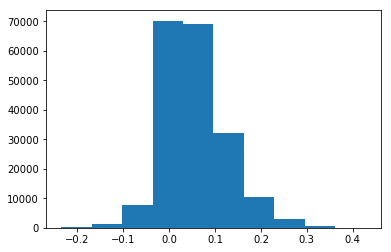

In [15]:
plt.hist(convexity_checks)

In [16]:
print('negative percent for Vlassis check')
print(neg_ct/ct*100)

negative percent for Vlassis check
14.768537800607772


(array([3.1291e+04, 8.2492e+04, 4.2182e+04, 2.2244e+04, 9.7220e+03,
        4.0800e+03, 1.7640e+03, 5.7000e+02, 1.2000e+02, 1.6000e+01]),
 array([-0.14206101,  0.03165974,  0.20538048,  0.37910122,  0.55282197,
         0.72654271,  0.90026345,  1.0739842 ,  1.24770494,  1.42142568,
         1.59514643]),
 <a list of 10 Patch objects>)

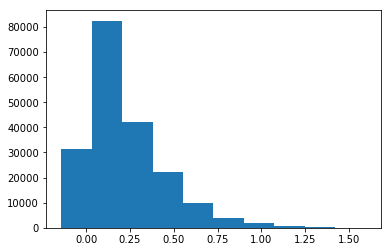

In [17]:
plt.hist(monotonicity_checks)

In [18]:
print('negative percent for monotonicity check')
print(neg_ct2/ct*100)

negative percent for monotonicity check
3.5448192882595215


In [20]:
import matplotlib.cm as cm
from matplotlib.tri import Triangulation, TriAnalyzer, UniformTriRefiner
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

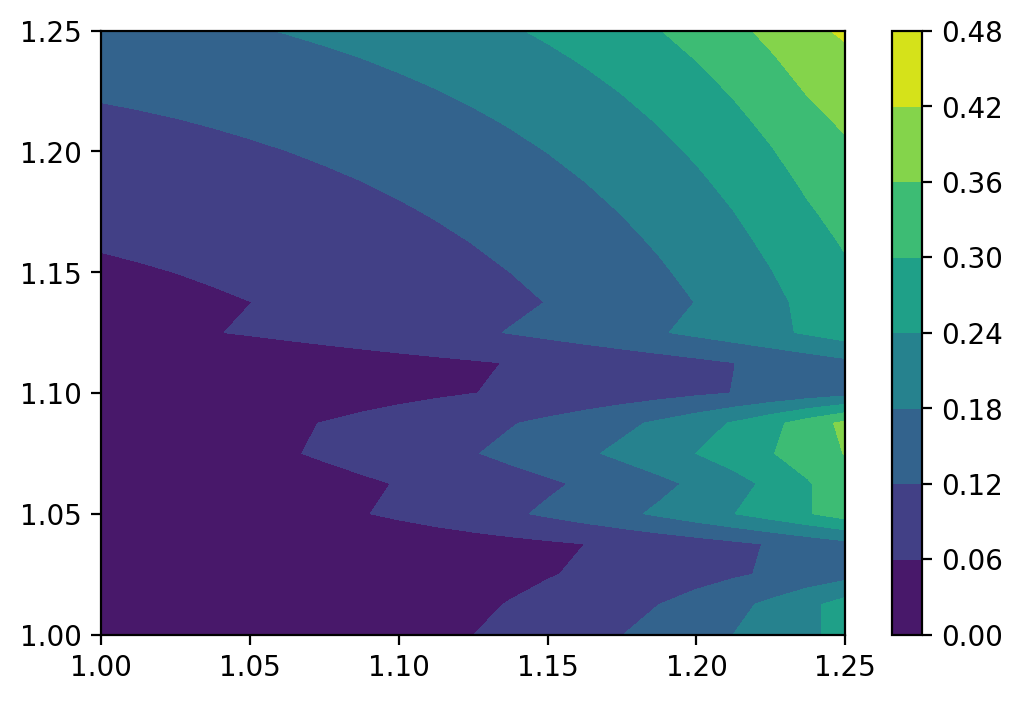

In [22]:

lamx_mg, lamy_mg = np.meshgrid(lamx_ls,lamy_ls)
Z_mg = Z_vec.reshape(nx,ny)
plt.contourf(lamx_mg,lamy_mg,Z_mg)
plt.colorbar()

In [23]:
lamx_ls

array([1.    , 1.0125, 1.025 , 1.0375, 1.05  , 1.0625, 1.075 , 1.0875,
       1.1   , 1.1125, 1.125 , 1.1375, 1.15  , 1.1625, 1.175 , 1.1875,
       1.2   , 1.2125, 1.225 , 1.2375, 1.25  ])